### Model 2, learning loop with constant discriminator accuracy.

Epoch [0/400], Step [200/938], d_loss: 0.5955, g_loss: 2.5338, D(x): 0.75, D(G(z)): 0.15, D Real Acc: 0.84, D Fake Acc: 0.91, Discriminator Loops: 1, G Steps: 1
Epoch [0/400], Step [400/938], d_loss: 0.4241, g_loss: 1.8832, D(x): 0.79, D(G(z)): 0.08, D Real Acc: 0.84, D Fake Acc: 0.92, Discriminator Loops: 1, G Steps: 4
Epoch [0/400], Step [600/938], d_loss: 0.2859, g_loss: 3.1248, D(x): 0.88, D(G(z)): 0.12, D Real Acc: 0.94, D Fake Acc: 0.97, Discriminator Loops: 1, G Steps: 1
Epoch [0/400], Step [800/938], d_loss: 0.3434, g_loss: 2.1017, D(x): 0.87, D(G(z)): 0.13, D Real Acc: 0.92, D Fake Acc: 0.95, Discriminator Loops: 1, G Steps: 1
Epoch [1/400], Step [200/938], d_loss: 0.5481, g_loss: 3.0552, D(x): 0.75, D(G(z)): 0.10, D Real Acc: 0.80, D Fake Acc: 0.98, Discriminator Loops: 1, G Steps: 1
Epoch [1/400], Step [400/938], d_loss: 0.5276, g_loss: 2.9656, D(x): 0.78, D(G(z)): 0.13, D Real Acc: 0.86, D Fake Acc: 0.98, Discriminator Loops: 2, G Steps: 1
Epoch [1/400], Step [600/938], d_l

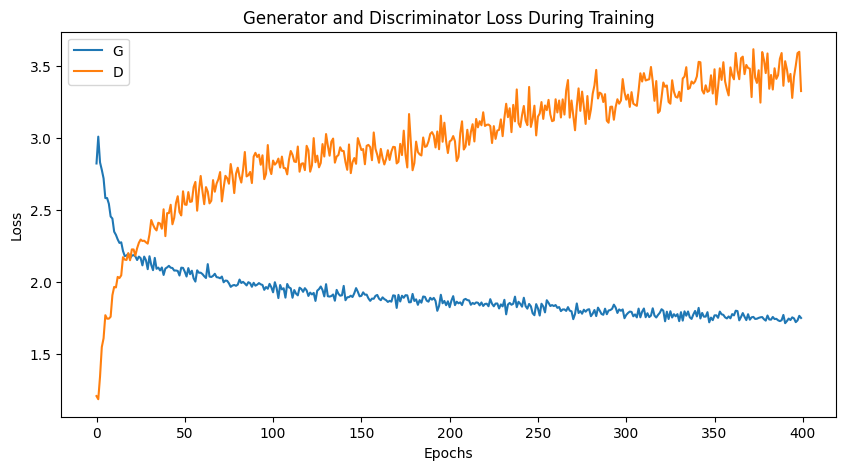

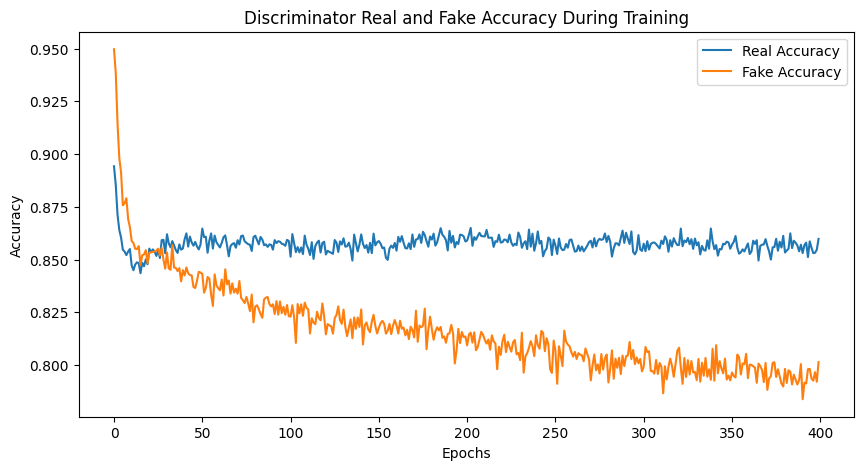

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 400
batch_size = 64
learning_rate = 0.0005
g_steps = 1
loop_reached_counter = 0

# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
start_time = time.time()

d_losses = []
g_losses = []
d_real_accuracies = []
d_fake_accuracies = []

for epoch in range(num_epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    d_real_accuracy_epoch = 0.0
    d_fake_accuracy_epoch = 0.0
    
    for i, (images, _) in enumerate(train_loader):
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        
        images = images.to(device)
        d_real_accuracy = 0.0
        d_fake_accuracy = 0.0
        discriminator_loops = 0
        # ================== Train discriminator ================== #
        while d_real_accuracy < 0.75 or d_fake_accuracy < 0.75:
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs.mean().item()
            d_real_accuracy = (outputs > 0.5).float().mean().item()
            
            z = torch.randn(images.size(0), latent_size).to(device)
            fake_images = generator(z)
            
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs.mean().item()
            d_fake_accuracy = (outputs < 0.5).float().mean().item()
            
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            discriminator_loops += 1
            d_loss_epoch += d_loss.item()
            if discriminator_loops > 10:
                loop_reached_counter += 1
                break
        if discriminator_loops <= 10:
            loop_reached_counter = 0

        # ================== Train generator ================== #
        if d_fake_accuracy > 0.99:
            g_steps = 4
        else:
            g_steps = 1
        for _ in range(g_steps):
            z = torch.randn(images.size(0), latent_size).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            d_fake_accuracy = (outputs < 0.5).float().mean().item()
            
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        d_real_accuracy_epoch += d_real_accuracy
        d_fake_accuracy_epoch += d_fake_accuracy
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}, D Real Acc: {:.2f}, D Fake Acc: {:.2f}, Discriminator Loops: {}, G Steps: {}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score, fake_score, d_real_accuracy, d_fake_accuracy, discriminator_loops, g_steps))
        
    
    d_losses.append(d_loss_epoch / total_step)
    g_losses.append(g_loss_epoch / total_step)
    d_real_accuracies.append(d_real_accuracy_epoch / total_step)
    d_fake_accuracies.append(d_fake_accuracy_epoch / total_step)
    
    if (epoch+1) % 1 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_size).to(device)
            fake_images = generator(z).view(-1, 28, 28).cpu().numpy()
            fig, axes = plt.subplots(4, 4, figsize=(8, 8))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i], cmap='gray')
                ax.axis('off')
            plt.savefig('v3/generated_images-{}.png'.format(epoch+1))
            plt.close()
    if loop_reached_counter == 5:
        print('Discriminator training loop limit reached five times in row. Stopping training.')
        break

end_time = time.time()
print(f'Training finished in {end_time - start_time:.2f} seconds.')

# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.title("Discriminator Real and Fake Accuracy During Training")
plt.plot(d_real_accuracies, label="Real Accuracy")
plt.plot(d_fake_accuracies, label="Fake Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [9]:
torch.save(generator.state_dict(), 'v3/generator.pth')
torch.save(discriminator.state_dict(), 'v3/discriminator.pth')

In [10]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("v3.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)
make_gif("v3")
